In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data',name='gb1')
print(f'training N: {len(data_df):,}')
data_df.head()

training N: 429,674


,input_ct,selected_ct,hamming_dist,training_set,y,dy,x
0,1759616.0,3041819.0,0,True,0.000000,0.001366,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,14663.0,38476.0,1,True,0.602044,0.014001,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,13001.0,23023.0,1,True,0.034732,0.015827,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,11488.0,18085.0,1,True,-0.135053,0.017212,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,9501.0,15629.0,1,True,-0.071659,0.018767,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(x=data_df['x'],
                     y=data_df['y'],
                     alphabet='protein',
                     gpmap_type='additive',
                     regression_type='GE',
                     ge_noise_model_type='Cauchy',
                     ge_heteroskedasticity_order=2)

# Fit model to data
history = model.fit(learning_rate=.005,
                    epochs=1000,
                    early_stopping=True,
                    early_stopping_patience=10)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has   429674 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1100

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.003e+03  1.029e+07   1.0e+00  1.1e+00
     1 -5.78821e-05  2.048e+03  2.130e+05   6.8e-01  2.2e-02  4.7e+03  1.0e+00
     2  9.47533e-02  1.158e+03  2.520e+04   3.9e-01  4.6e-03  4.7e+03  3.7e+01
     3  1.57804e-01  8.117e+02  1.395e+04   2.7e-01  3.7e-03  4.7e+03  1.6e+02
     4  1.86615e-01  7.552e+02  2.512e+03   2.5e-01  7.1e-04  4.7e+03  1.3e+02
     5  1.87539e-01  7.551e+02  5.145e+02   2.5e-01  1.0e-04  6.6e+03  1.3e+02
     6  1.86308e-01  7.551e+02  4.648e+02   2.5e-01  9.3e-05  6.6e+03  1.3e+02
     7  1.74875e-01  7.549e+02  4.653e+01   2.5e-01  9.3e-06  6.6e+03  1.3e+02
     8  1.74796e-01  7.549e+02  4.461e+01   2.5e-01  8.9e-06  6.6e+03  1.3

In [4]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [5]:
# Load model
model = mavenn.load('gb1_ge_additive')

Model loaded from these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


In [6]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='gb1')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < .1

# Get x and y
x = test_df['x'].values[ix]
y = test_df['y'].values[ix]

test data N: 107,289


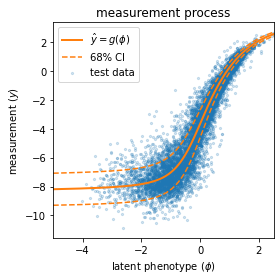

In [7]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

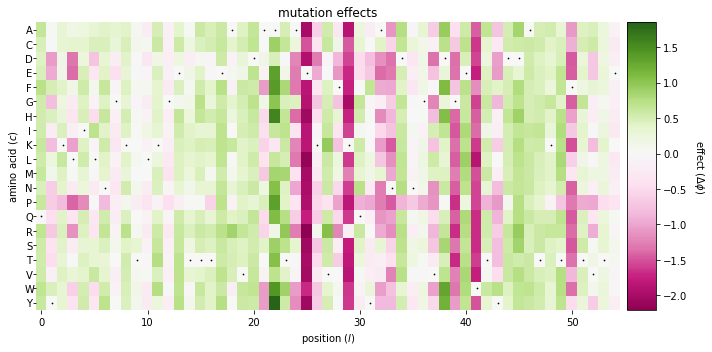

In [8]:
# Set wild-type sequence
gb1_seq = mavenn.x_to_consensus(x)

# Get effects of all single-point mutations on phi
dphi_df = mavenn.get_1pt_effects(func=model.x_to_phi,
                                 wt_seq=gb1_seq,
                                 alphabet='protein')

# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[10, 5])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb = mavenn.heatmap(dphi_df,
                        c_col='c_mut',
                        l_col='l',
                        value_col='dphi',
                        seq=gb1_seq,
                        ccenter=0,
                        missing_values=0,
                        cmap='PiYG',
                        ax=ax)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax.set_title('mutation effects')

# Fix up plot
fig.tight_layout()
plt.show()
